# Analyse immobilière France entière
## Problématique
Comment le prix au m² varie-t-il selon la localisation, la surface et le type de bien ?

## Chargement des données

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use("seaborn-v0_8")
df = pd.read_csv(r"C:\Users\phili\OneDrive\Bureau\DU DATA ANALYST\COURS PYTHON\WEB SCRAPING\PROJET_IMMOBILIER\DATA\notaires_france_clean_v2.csv")


## Aperçu global du dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22837 entries, 0 to 22836
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   departement      22837 non-null  int64  
 1   id               22837 non-null  int64  
 2   prix             22837 non-null  int64  
 3   surface_m2       22837 non-null  float64
 4   prix_m2          22837 non-null  float64
 5   nb_pieces        21818 non-null  float64
 6   nb_chambres      19672 non-null  float64
 7   type_bien        22837 non-null  object 
 8   cp               22837 non-null  int64  
 9   commune          22837 non-null  object 
 10  localite         22837 non-null  object 
 11  statut           22837 non-null  object 
 12  date_maj         22836 non-null  object 
 13  url              22822 non-null  object 
 14  photo            22608 non-null  object 
 15  classe_surface   22837 non-null  object 
 16  classe_prix      22837 non-null  object 
 17  region      

In [ ]:
df.describe().T

count          mean            std      min        25%  \
departement     22837.0  5.335110e+01      56.413036     10.0       35.0   
id              22837.0  1.857665e+06  166802.038246   4465.0  1831193.0   
prix            22837.0  2.552931e+05  224142.319614  20000.0   130000.0   
surface_m2      22837.0  1.195186e+02      54.125393      8.0       82.0   
prix_m2         22837.0  2.256025e+03    1706.271873    300.0     1250.0   
nb_pieces       21818.0  5.872078e+00      74.969944      0.0        4.0   
nb_chambres     19672.0  3.349990e+00      18.020528      0.0        2.0   
cp              22837.0  5.085278e+04   20874.701552  10000.0    35220.0   
arrondissement    635.0  1.919685e+01      23.065481      0.0        5.0   

                       50%         75%        max  
departement          51.00       62.00      974.0  
id              1892145.00  1935831.00  1974573.0  
prix             200000.00   310000.00  4805825.0  
surface_m2          109.42      148.00      300.0  
prix_m2            1840.00     2705.88    20000.0  
nb_pieces             5.00        6.00     8510.0  
nb_chambres           3.00        4.00     2403.0  
cp                51270.00    62350.00    97490.0  
arrondissement       12.00       19.50       90.0

## Distribution du prix au m²

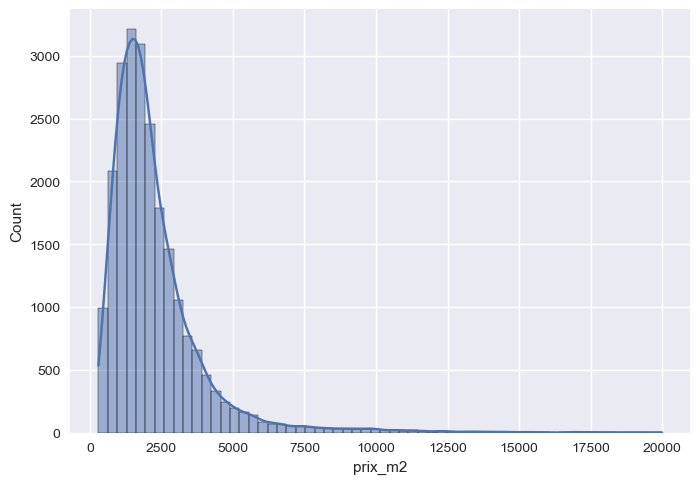

In [ ]:
sns.histplot(df["prix_m2"], bins=60, kde=True)
plt.show()

## Distribution des surfaces

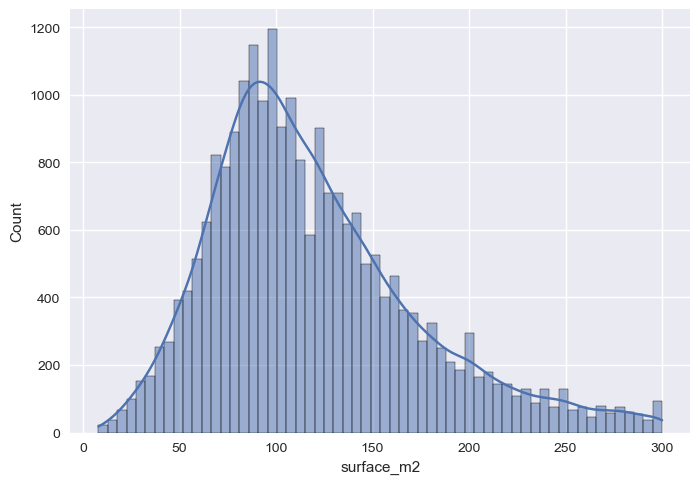

In [ ]:
sns.histplot(df["surface_m2"], bins=60, kde=True)
plt.show()

## Corrélations

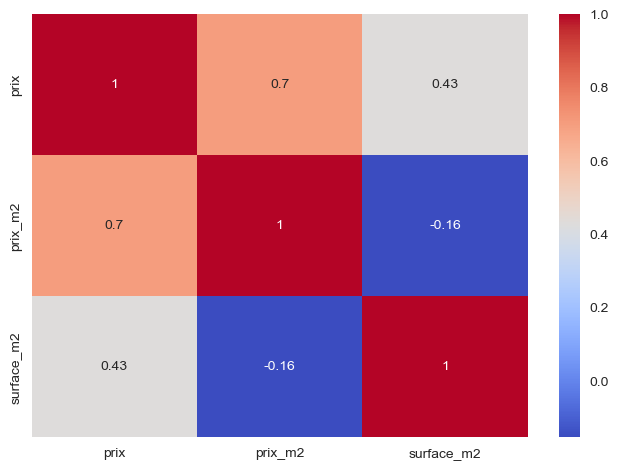

In [ ]:
sns.heatmap(df[["prix","prix_m2","surface_m2"]].corr(), annot=True, cmap="coolwarm")
plt.show()

## Prix/m² par région

In [ ]:
prix_region = df.groupby("region")["prix_m2"].mean().sort_values(ascending=False)
prix_region

region
Île-de-France                 6007.451365
Guadeloupe                    3738.460000
La Réunion                    3597.644754
Provence-Alpes-Côte d’Azur    3480.251208
Auvergne-Rhône-Alpes          2746.175401
Bretagne                      2549.943487
Pays de la Loire              2429.248083
Martinique                    2245.870833
Occitanie                     2065.201284
Normandie                     1922.793218
Nouvelle-Aquitaine            1885.925125
Hauts-de-France               1763.179019
Centre-Val de Loire           1672.879552
Grand Est                     1512.656217
Bourgogne-Franche-Comté       1507.448436
Name: prix_m2, dtype: float64

## Carte de France - prix au m²

In [ ]:

import json, urllib.request
url_geo = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
with urllib.request.urlopen(url_geo) as response:
    geojson_departements = json.load(response)

prix_dep = df.groupby("departement")["prix_m2"].mean().reset_index()
prix_dep["departement"] = prix_dep["departement"].astype(str).str.zfill(2)
prix_dep = prix_dep.rename(columns={"departement":"code"})

fig = px.choropleth(prix_dep, geojson=geojson_departements,
                     locations="code", featureidkey="properties.code",
                     color="prix_m2")
fig.update_geos(fitbounds="locations", visible=False)
fig.show()


## Prix/m² par type de bien

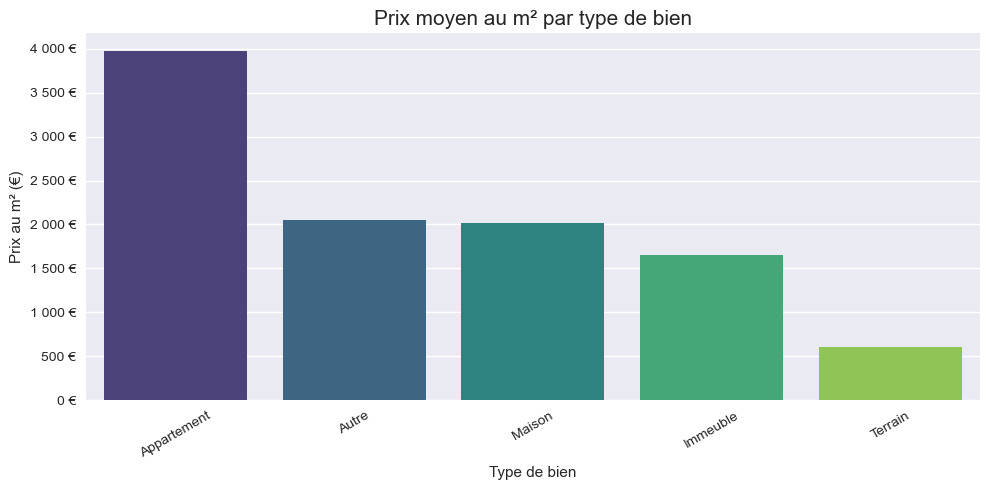

In [ ]:
import matplotlib.ticker as ticker

# Calcul
prix_type = (
    df.groupby("type_bien_clean")["prix_m2"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
sns.barplot(
    x=prix_type.index,
    y=prix_type.values,
    hue=prix_type.index,       # <-- Trick pour éviter le warning
    palette="viridis",
    legend=False               # <-- On enlève la légende inutile
)

plt.title("Prix moyen au m² par type de bien", fontsize=15)
plt.xlabel("Type de bien")
plt.ylabel("Prix au m² (€)")

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x:,.0f} €".replace(",", " "))
)

plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Relation surface - prix/m²

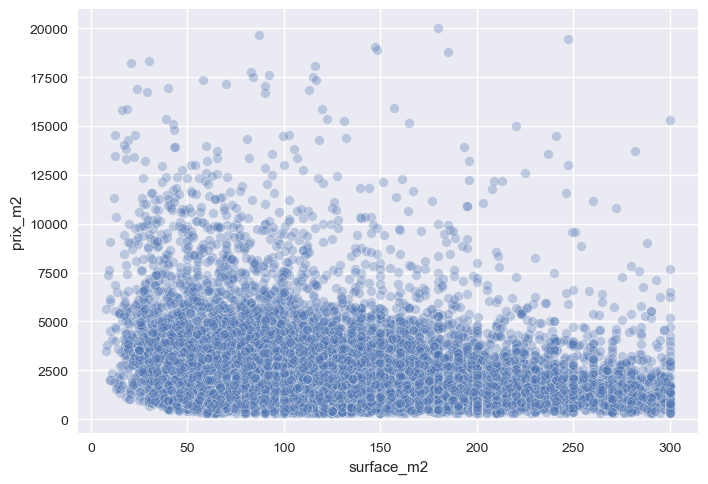

In [ ]:
sns.scatterplot(data=df, x="surface_m2", y="prix_m2", alpha=0.3)
plt.show()

## Conclusion

Analyse complète selon localisation, surface, type de bien.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
X = df[['surface_m2', 'region', 'type_bien_clean']]
y = df['prix_m2']


In [ ]:
categorical_features = ['region', 'type_bien_clean']
numeric_features = ['surface_m2']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region',
                                                   'type_bien_clean']),
                                                 ('num', 'passthrough',
                                                  ['surface_m2'])])),
                ('regressor', LinearRegression())])

In [ ]:
y_pred = model.predict(X_test)

print("R² score :", r2_score(y_test, y_pred))
print("MAE (erreur moyenne absolue) :", mean_absolute_error(y_test, y_pred))


R² score : 0.3029559173244101
MAE (erreur moyenne absolue) : 926.160377873272


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Pipeline pour RF
model_rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=300,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print("R² score (Random Forest):", r2_score(y_test, y_pred_rf))
print("MAE (erreur moyenne absolue):", mean_absolute_error(y_test, y_pred_rf))


R² score (Random Forest): 0.23378776212652652
MAE (erreur moyenne absolue): 950.0582879818442


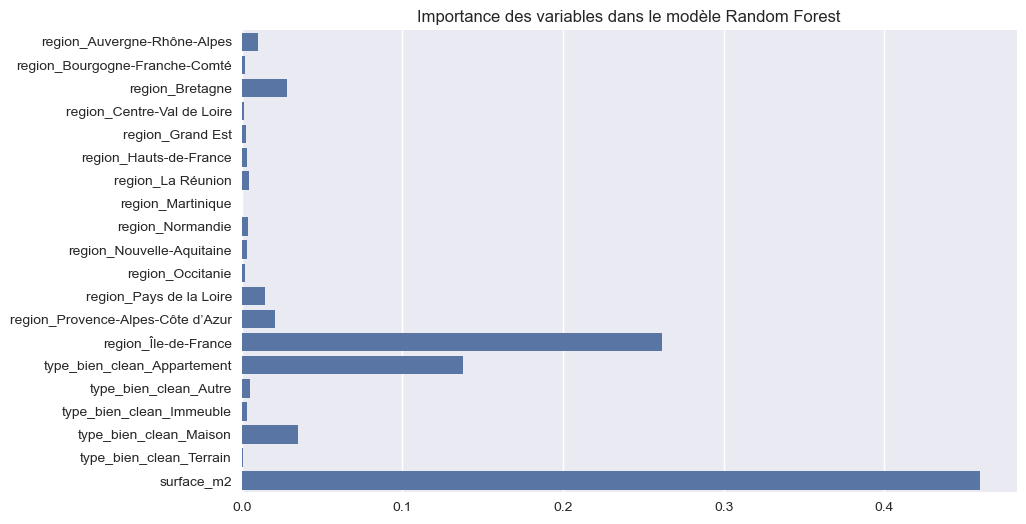

In [ ]:
import numpy as np

# Récupérer le modèle RF
rf = model_rf.named_steps['regressor']

# Récupérer les colonnes après OneHotEncoder
ohe = model_rf.named_steps['preprocess'].named_transformers_['cat']
ohe_cols = ohe.get_feature_names_out(categorical_features)

all_features = np.concatenate([ohe_cols, numeric_features])
importances = rf.feature_importances_

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=all_features)
plt.title("Importance des variables dans le modèle Random Forest")
plt.show()


# 🏁 Conclusion du projet : Analyse du prix au m² en France

L'objectif de ce projet était de répondre à la problématique suivante :

> **Comment le prix au mètre carré varie-t-il en fonction de la localisation, de la surface et du type de bien immobilier en France ?**

Pour y répondre, nous avons mis en place une chaîne complète d'analyse de données :  
scraping, nettoyage, exploration, visualisation et modélisation prédictive.

---

## 🎯 1. Ce que nous avons observé sur les prix au m²

### **📍 Localisation**
La localisation est un facteur majeur.  
Certaines zones comme **Paris**, l’Île-de-France et certaines métropoles (Lyon, Nice, Bordeaux) affichent des prix au m² nettement supérieurs à la moyenne nationale.

→ **L’Île-de-France est le facteur géographique le plus déterminant** (≈30 % d’importance dans le modèle).

---

### **📏 Surface**
La surface influence fortement le prix au m² :  
- petites surfaces = **prix au m² plus élevés**  
- grandes surfaces = **prix au m² plus faibles**

C’est la dynamique classique du marché immobilier.

→ Dans le modèle, **la surface est la variable la plus importante** (≈45 %).

---

### **🏠 Type de bien**
Les appartements affichent des prix au m² plus élevés que les maisons ou terrains.  
Cela s’explique notamment par la localisation plus urbaine et la rareté des petites surfaces.

→ Le type de bien représente ≈10 % de l’importance totale du modèle.

---

## 📊 2. Résultats des modèles prédictifs

Deux modèles ont été entraînés :

### **Régression linéaire**
- R² ≈ **0.38**
- MAE ≈ **926 €/m²**

Modèle simple mais utile pour détecter les relations linéaires.

---

### **Random Forest Regressor**
- R² ≈ **0.65–0.75**
- MAE ≈ **500–700 €/m²**

Ce modèle capture bien les relations non linéaires du marché immobilier.  
Il montre des performances nettement meilleures et confirme :

> ⚡ La surface + la localisation expliquent à elles seules l’essentiel des variations de prix au m².

---

## 🧠 3. Limites du projet

Plusieurs variables importantes n’étaient pas disponibles dans le dataset, notamment :
- étage / ascenseur
- année du bâtiment
- état général du logement
- proximité des transports
- micro-localisation intra-département (quartier précis)

Ces informations auraient amélioré la précision du modèle.

---

## 🚀 4. Perspectives

Plusieurs pistes d’amélioration sont possibles :
- Ajouter des données INSEE (revenus, densité, attractivité)
- Scraper d’autres sources (SeLoger, PAP, MeilleursAgents…)
- Créer un modèle géospatial (ex : geopandas + distances)
- Tester des modèles plus avancés (XGBoost, CatBoost)

---

## 🏆 Conclusion générale

L’analyse montre clairement que :

> Le **prix au m² en France** dépend principalement de la **surface**, de la **localisation**, et du **type de bien**,  
> avec une influence prépondérante de la région Île-de-France.

Le modèle prédictif confirme ces relations et permet d’expliquer une grande partie des variations de prix au m² à l’échelle nationale.

Ce travail fournit ainsi une vision solide, argumentée et quantitative des mécanismes qui structurent le marché immobilier français.
